<a href="https://colab.research.google.com/github/jordanjoelson/gdsc-ml/blob/main/ImageCheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
"""
HAM10000 Dataset Validation - Google Colab Version
Date: 2026-02-03
"""

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install any missing packages (Colab has most pre-installed)
!pip install -q seaborn scikit-learn

print(" Setup complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Setup complete!


In [6]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(" Libraries imported!")

✅ Libraries imported!


In [7]:
# CONFIGURE THESE PATHS TO MATCH YOUR GOOGLE DRIVE STRUCTURE

# Path to metadata CSV (directly in MyDrive)
METADATA_PATH = '/content/drive/MyDrive/HAM10000_metadata.csv'

# Paths to the two image folders
IMAGE_DIR_1 = '/content/drive/MyDrive/HAM10000_images_part_1'
IMAGE_DIR_2 = '/content/drive/MyDrive/HAM10000_images_part_2'

# Both image directories as a list
IMAGE_DIRS = [IMAGE_DIR_1, IMAGE_DIR_2]

print("="*70)
print("CHECKING PATHS...")
print("="*70)

# Check metadata
if os.path.exists(METADATA_PATH):
    print(f" Metadata found: {METADATA_PATH}")
else:
    print(f"Metadata NOT found: {METADATA_PATH}")

# Check image folders
for idx, img_dir in enumerate(IMAGE_DIRS, 1):
    if os.path.exists(img_dir):
        num_files = len([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
        print(f" Image folder {idx} found: {img_dir}")
        print(f"   Contains {num_files:,} .jpg files")
    else:
        print(f"Image folder {idx} NOT found: {img_dir}")

print("="*70)

CHECKING PATHS...
✅ Metadata found: /content/drive/MyDrive/HAM10000_metadata.csv
✅ Image folder 1 found: /content/drive/MyDrive/HAM10000_images_part_1
   Contains 5,000 .jpg files
✅ Image folder 2 found: /content/drive/MyDrive/HAM10000_images_part_2
   Contains 5,015 .jpg files


In [8]:
class HAM10000Validator:
    """Comprehensive validation for HAM10000 dataset - Two Folder Version"""

    def __init__(self, image_dirs, metadata_path):
        """
        Initialize validator with paths

        Args:
            image_dirs: List of image directory paths
            metadata_path: Path to metadata CSV
        """
        self.image_dirs = image_dirs if isinstance(image_dirs, list) else [image_dirs]
        self.metadata_path = metadata_path

        # Validation results
        self.results = {
            'file_integrity': None,
            'image_properties': None,
            'label_distribution': None,
            'metadata_quality': None,
            'overall_status': None
        }

    def _get_all_image_files(self):
        """Get all image files from both directories"""
        all_files = []
        for img_dir in self.image_dirs:
            if os.path.exists(img_dir):
                files = [(os.path.join(img_dir, f), f) for f in os.listdir(img_dir)
                        if f.endswith('.jpg')]
                all_files.extend(files)
        return all_files

    def validate_all(self):
        """Run all validation checks"""
        print("="*70)
        print("HAM10000 DATASET VALIDATION (TWO FOLDER VERSION)")
        print("="*70)
        print(f"Image folders: {len(self.image_dirs)}")
        for idx, img_dir in enumerate(self.image_dirs, 1):
            print(f"  Folder {idx}: {img_dir}")
        print()

        # Run each validation
        self.check_file_integrity()
        self.check_image_properties()
        self.check_label_distribution()
        self.check_metadata_quality()

        # Generate report
        self.generate_report()

        return self.results

    def check_file_integrity(self):
        """Validate file counts and integrity"""
        print("\n" + "="*70)
        print("1. FILE INTEGRITY CHECK")
        print("="*70)

        try:
            # Load metadata
            df = pd.read_csv(self.metadata_path)
            metadata_count = len(df)

            # Count images in each folder
            total_images = 0
            for idx, img_dir in enumerate(self.image_dirs, 1):
                if os.path.exists(img_dir):
                    count = len([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
                    print(f"Folder {idx} ({os.path.basename(img_dir)}): {count:,} images")
                    total_images += count
                else:
                    print(f"Folder {idx} not found: {img_dir}")

            print(f"\nTotal image files: {total_images:,}")
            print(f"Metadata records: {metadata_count:,}")

            # Get all image files
            all_files = self._get_all_image_files()

            # Check for corrupted images (sample)
            print(f"\nChecking image integrity (sampling 200 images)...")
            corrupted = []
            sample_size = min(200, len(all_files))

            for img_path, img_name in all_files[:sample_size]:
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                except Exception as e:
                    corrupted.append(img_name)

            if corrupted:
                print(f" Found {len(corrupted)} corrupted images:")
                for c in corrupted[:5]:  # Show first 5
                    print(f"   - {c}")
                self.results['file_integrity'] = 'FAIL'
            elif metadata_count == total_images:
                print(" All files intact! Counts match perfectly.")
                self.results['file_integrity'] = 'PASS'
            else:
                diff = abs(metadata_count - total_images)
                print(f"⚠️  WARNING: Count mismatch ({diff} difference)")
                print(f"   Metadata: {metadata_count:,}, Actual files: {total_images:,}")
                self.results['file_integrity'] = 'WARNING'

        except Exception as e:
            print(f"ERROR: {str(e)}")
            self.results['file_integrity'] = 'FAIL'

    def check_image_properties(self):
        """Validate image dimensions, formats, color modes"""
        print("\n" + "="*70)
        print("2. IMAGE PROPERTIES CHECK")
        print("="*70)

        try:
            all_files = self._get_all_image_files()
            sample_size = min(500, len(all_files))

            print(f"Analyzing {sample_size} sample images from both folders...\n")

            dimensions = []
            formats = []
            modes = []
            file_sizes = []

            for img_path, img_name in all_files[:sample_size]:
                try:
                    with Image.open(img_path) as img:
                        dimensions.append(img.size)
                        formats.append(img.format)
                        modes.append(img.mode)
                        file_sizes.append(os.path.getsize(img_path) / 1024)  # KB
                except:
                    continue

            # Analyze dimensions
            unique_dims = set(dimensions)
            print(f"Image Dimensions:")
            for dim in sorted(unique_dims):
                count = dimensions.count(dim)
                pct = (count / len(dimensions)) * 100
                print(f"  {dim[0]}x{dim[1]}: {count} images ({pct:.1f}%)")

            # Analyze formats
            print(f"\nFile Formats:")
            for fmt in set(formats):
                count = formats.count(fmt)
                print(f"  {fmt}: {count} images")

            # Analyze color modes
            print(f"\nColor Modes:")
            for mode in set(modes):
                count = modes.count(mode)
                print(f"  {mode}: {count} images")

            # File size stats
            print(f"\nFile Sizes (KB):")
            print(f"  Min: {min(file_sizes):.1f} KB")
            print(f"  Max: {max(file_sizes):.1f} KB")
            print(f"  Mean: {np.mean(file_sizes):.1f} KB")
            print(f"  Median: {np.median(file_sizes):.1f} KB")

            # Check for issues
            issues = []
            if len(unique_dims) > 1:
                issues.append("Multiple image dimensions detected")
            if 'L' in modes or 'LA' in modes:
                issues.append("Grayscale images found (need RGB conversion)")

            if issues:
                print(f"\n  Warnings:")
                for issue in issues:
                    print(f"   - {issue}")
                self.results['image_properties'] = 'WARNING'
            else:
                print("\n All images have consistent properties!")
                self.results['image_properties'] = 'PASS'

        except Exception as e:
            print(f"ERROR: {str(e)}")
            self.results['image_properties'] = 'FAIL'

    def check_label_distribution(self):
        """Analyze class distribution and imbalance"""
        print("\n" + "="*70)
        print("3. LABEL DISTRIBUTION CHECK")
        print("="*70)

        try:
            df = pd.read_csv(self.metadata_path)

            # Class distribution
            class_counts = df['dx'].value_counts()
            total = len(df)

            print(f"Total images: {total:,}\n")
            print("Class Distribution:")
            print("-" * 50)

            for cls, count in class_counts.items():
                pct = (count / total) * 100
                bar = "█" * int(pct / 2)
                print(f"{cls:8s}: {count:5,} ({pct:5.1f}%) {bar}")

            # Calculate imbalance ratio
            max_count = class_counts.max()
            min_count = class_counts.min()
            imbalance_ratio = max_count / min_count

            print(f"\nImbalance Analysis:")
            print(f"  Largest class: {class_counts.idxmax()} ({max_count:,} images)")
            print(f"  Smallest class: {class_counts.idxmin()} ({min_count:,} images)")
            print(f"  Imbalance ratio: {imbalance_ratio:.1f}:1")

            # Create visualization
            self._plot_class_distribution(class_counts)

            if imbalance_ratio > 10:
                print(f"\n  SEVERE class imbalance detected!")
                print("   Recommendation: Use class weights or resampling")
                self.results['label_distribution'] = 'WARNING'
            else:
                print(f"\n Class distribution acceptable")
                self.results['label_distribution'] = 'PASS'

        except Exception as e:
            print(f" ERROR: {str(e)}")
            self.results['label_distribution'] = 'FAIL'

    def check_metadata_quality(self):
        """Check metadata completeness and quality"""
        print("\n" + "="*70)
        print("4. METADATA QUALITY CHECK")
        print("="*70)

        try:
            df = pd.read_csv(self.metadata_path)

            print(f"Total records: {len(df):,}")
            print(f"Columns: {', '.join(df.columns)}\n")

            # Missing values
            missing = df.isnull().sum()
            total_missing = missing.sum()

            print("Missing Values:")
            if total_missing > 0:
                for col, count in missing.items():
                    if count > 0:
                        pct = (count / len(df)) * 100
                        print(f"  {col}: {count:,} ({pct:.2f}%)")
            else:
                print("  None - All fields complete!")

            # Data types
            print(f"\nData Types:")
            for col, dtype in df.dtypes.items():
                print(f"  {col}: {dtype}")

            # Age statistics (if available)
            if 'age' in df.columns:
                print(f"\nAge Statistics:")
                print(f"  Count: {df['age'].count():,}")
                print(f"  Mean: {df['age'].mean():.1f} years")
                print(f"  Median: {df['age'].median():.1f} years")
                print(f"  Range: {df['age'].min():.0f} - {df['age'].max():.0f} years")

            # Sex distribution (if available)
            if 'sex' in df.columns:
                print(f"\nSex Distribution:")
                sex_counts = df['sex'].value_counts()
                for sex, count in sex_counts.items():
                    pct = (count / len(df)) * 100
                    print(f"  {sex}: {count:,} ({pct:.1f}%)")

            # Localization (if available)
            if 'localization' in df.columns:
                print(f"\nTop 5 Body Locations:")
                loc_counts = df['localization'].value_counts().head(5)
                for loc, count in loc_counts.items():
                    pct = (count / len(df)) * 100
                    print(f"  {loc}: {count:,} ({pct:.1f}%)")

            # Check for duplicates
            duplicates = df.duplicated(subset=['image_id']).sum()
            if duplicates > 0:
                print(f"\n WARNING: {duplicates} duplicate image IDs found!")
                self.results['metadata_quality'] = 'WARNING'
            else:
                print(f"\n No duplicate image IDs")

            if total_missing == 0:
                self.results['metadata_quality'] = 'PASS'
            elif total_missing < len(df) * 0.05:  # Less than 5% missing
                self.results['metadata_quality'] = 'WARNING'
            else:
                self.results['metadata_quality'] = 'FAIL'

        except Exception as e:
            print(f"ERROR: {str(e)}")
            self.results['metadata_quality'] = 'FAIL'

    def _plot_class_distribution(self, class_counts):
        """Create and display class distribution visualization"""
        try:
            plt.figure(figsize=(12, 6))

            # Create bar plot
            colors = sns.color_palette('viridis', len(class_counts))
            bars = plt.bar(range(len(class_counts)), class_counts.values, color=colors)

            plt.title('HAM10000 Class Distribution', fontsize=16, fontweight='bold', pad=20)
            plt.xlabel('Diagnosis Class', fontsize=12)
            plt.ylabel('Number of Images', fontsize=12)
            plt.xticks(range(len(class_counts)), class_counts.index, rotation=45, ha='right')

            # Add value labels on bars
            for i, (bar, v) in enumerate(zip(bars, class_counts.values)):
                plt.text(bar.get_x() + bar.get_width()/2, v + 100,
                        f'{v:,}', ha='center', va='bottom', fontsize=10)

            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()

            # Display in Colab
            plt.show()

            print(f"\n Visualization displayed above")

        except Exception as e:
            print(f"Warning: Could not create visualization: {str(e)}")

    def generate_report(self):
        """Generate final validation report"""
        print("\n" + "="*70)
        print("VALIDATION SUMMARY")
        print("="*70)

        # Print results
        for check, result in self.results.items():
            if result == 'PASS':
                status = "PASS"
            elif result == 'WARNING':
                status = "WARNING"
            elif result == 'FAIL':
                status = "FAIL"
            else:
                status = "NOT RUN"

            print(f"{check.replace('_', ' ').title():30s}: {status}")

        # Overall status
        failed = sum(1 for v in self.results.values() if v == 'FAIL')
        warnings = sum(1 for v in self.results.values() if v == 'WARNING')

        if failed > 0:
            overall = "VALIDATION FAILED"
            self.results['overall_status'] = 'FAIL'
        elif warnings > 0:
            overall = "VALIDATION PASSED WITH WARNINGS"
            self.results['overall_status'] = 'WARNING'
        else:
            overall = "VALIDATION PASSED"
            self.results['overall_status'] = 'PASS'

        print("="*70)
        print(f"Overall Status: {overall}")
        print("="*70)

print("✅ Validator class defined!")


✅ Validator class defined!


HAM10000 DATASET VALIDATION (TWO FOLDER VERSION)
Image folders: 2
  Folder 1: /content/drive/MyDrive/HAM10000_images_part_1
  Folder 2: /content/drive/MyDrive/HAM10000_images_part_2


1. FILE INTEGRITY CHECK
Folder 1 (HAM10000_images_part_1): 5,000 images
Folder 2 (HAM10000_images_part_2): 5,015 images

Total image files: 10,015
Metadata records: 10,015

Checking image integrity (sampling 200 images)...
✅ All files intact! Counts match perfectly.

2. IMAGE PROPERTIES CHECK
Analyzing 500 sample images from both folders...

Image Dimensions:
  600x450: 500 images (100.0%)

File Formats:
  JPEG: 500 images

Color Modes:
  RGB: 500 images

File Sizes (KB):
  Min: 125.6 KB
  Max: 393.0 KB
  Mean: 266.5 KB
  Median: 268.2 KB

✅ All images have consistent properties!

3. LABEL DISTRIBUTION CHECK
Total images: 10,015

Class Distribution:
--------------------------------------------------
nv      : 6,705 ( 66.9%) █████████████████████████████████
mel     : 1,113 ( 11.1%) █████
bkl     : 1,099 (

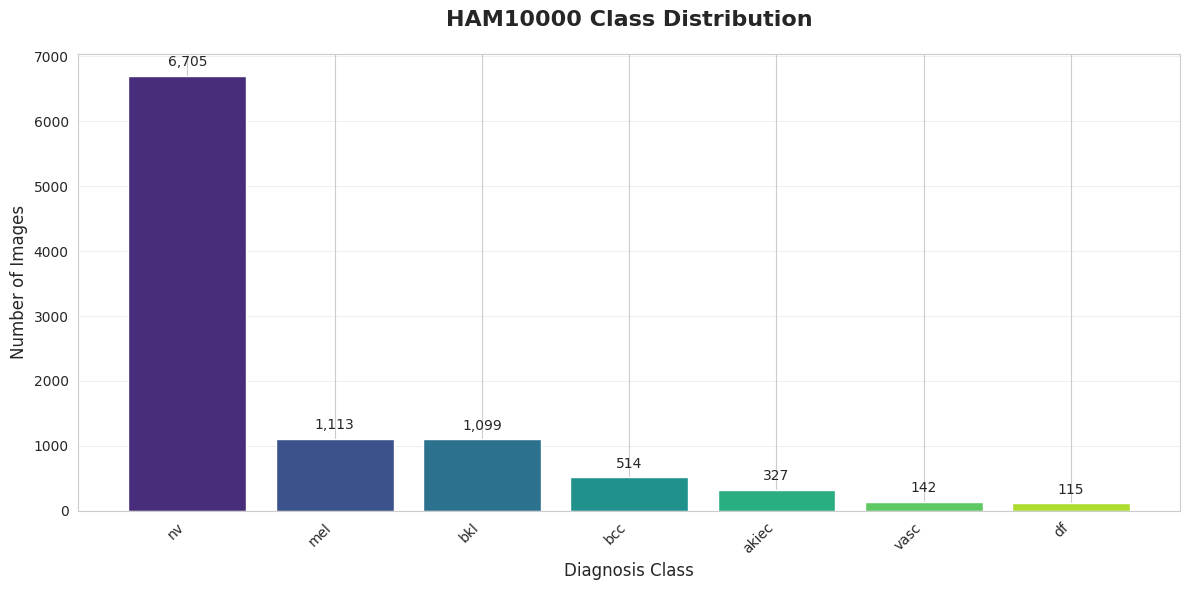


📊 Visualization displayed above

⚠️  SEVERE class imbalance detected!
   Recommendation: Use class weights or resampling

4. METADATA QUALITY CHECK
Total records: 10,015
Columns: lesion_id, image_id, dx, dx_type, age, sex, localization

Missing Values:
  age: 57 (0.57%)

Data Types:
  lesion_id: object
  image_id: object
  dx: object
  dx_type: object
  age: float64
  sex: object
  localization: object

Age Statistics:
  Count: 9,958
  Mean: 51.9 years
  Median: 50.0 years
  Range: 0 - 85 years

Sex Distribution:
  male: 5,406 (54.0%)
  female: 4,552 (45.5%)
  unknown: 57 (0.6%)

Top 5 Body Locations:
  back: 2,192 (21.9%)
  lower extremity: 2,077 (20.7%)
  trunk: 1,404 (14.0%)
  upper extremity: 1,118 (11.2%)
  abdomen: 1,022 (10.2%)

✅ No duplicate image IDs

VALIDATION SUMMARY
File Integrity                : ✅ PASS
Image Properties              : ✅ PASS
Label Distribution            : ⚠️  WARNING
Metadata Quality              : ⚠️  WARNING
Overall Status                : ❓ NOT RUN


In [9]:
# Initialize validator with your two-folder structure
validator = HAM10000Validator(
    image_dirs=IMAGE_DIRS,  # ← CHANGED: Now passes list of folders
    metadata_path=METADATA_PATH
)

# Run all validation checks
results = validator.validate_all()

# Store results for later use
print("\n" + "="*70)
print("Validation complete! Results stored in 'results' variable")
print("="*70)